In [1]:
# As first  example we  plan to  augment the BAT157 
# month source catalog  thourgh simple iteration over the data 
#  bootstrapping an error fluctuation

# we refer to this blog: https://towardsdatascience.com/time-series-bootstrap-in-the-age-of-deep-learning-b98aa2aa32c4
# https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/TimeSeries_Bootstrap/TimeSeries_Bootstrap.ipynb



In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

C:\Users\curti\AppData\Local\Temp/ipykernel_16108/2485775091.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# we need to increase the number of files that can be opened
# https://github.com/spacetelescope/drizzlepac/issues/39
# See also here: https://stackoverflow.com/questions/16526783/python-subprocess-too-many-open-files
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

ModuleNotFoundError: No module named 'resource'

In [ ]:
cosmo.luminosity_distance(0.1).value*1e6

460295897.01046604

In [ ]:
# now take the BAT157 month  catalog
import glob
from astropy.io import fits
 
data_dir='./BAT_157m_eight_band_monthly_lightcurve'

file_list = glob.glob(data_dir+'/*.lc')
#print(file_list[0:5])
# data1=[ triplet, name, coordinate]
data1 =[[],[],[]]

##  Creating bands vector for mean and variance calculation
b1, b2, b3, b4, b5, b6, b7, b8=[],[],[],[],[],[],[],[]


for a in file_list:
    rate150=[]
    rate150er=[]
    
    file1 = fits.open(a,memmap=True)
    Time = file1[1].data['TIME']
    # we could not use CENT_RATE (see Amy Lien emails) and then sum all bands
    # 
    Rate = file1[1].data['RATE']
    Rateerror = file1[1].data['RATE_ERR']
    Name = file1[1].data['NAME'][0]
    Raobj =  file1[1].data['RA_OBJ '][0]
    Decobj = file1[1].data['DEC_OBJ'] [0]
    file1.close()
    
    
    #################
    
    # This is necessary because the rate is a 9 element array, 
    # divide by energy blocks 
    rate150= [np.sum(x, axis=0)for x in Rate]
    rate150er=[np.sqrt(np.sum(np.square(x)))  for x in Rateerror]
    #print(np.shape(rate150))
    #print(len(rate150))
    #data1[0].append([Time,rate150,rate150er])
    
    ####  We keep all 9 bands: 
    # 14-20,20-24,24-35,35-50,50-75,75-100,100-150,150-195, and total counts/s 
    #keV
    # we store the transpose of the Rate/error so  that the last raw is the total count
    
    ##############   Let's cut the matrx from 1-8 raws and 1-155 columns
    rate_new=Rate.T[:-1]
    rate_ErrNew=Rateerror.T[:-1]
    
    
    
    ###############  
    b1.append(np.array(rate_new[0]))
    b2.append(np.array(rate_new[1]))
    b3.append(np.array(rate_new[2]))
    b4.append(np.array(rate_new[3]))
    b5.append(np.array(rate_new[4]))
    b6.append(np.array(rate_new[5]))
    b7.append(np.array(rate_new[6]))
    b8.append(np.array(rate_new[7]))
    
    
    if rate_new.shape[1]>= 155: 
        #print(rat_new.shape)
        #print(rate_new[:,:155])
        data1[0].append([Time[:155],rate_new[:,:155],rate_ErrNew[:,:155]])
    else:
        print('Some object has less than 155 observations')    
    
    data1[1].append(Name)
    data1[2].append([Raobj,Decobj])
    
print(len(b1))    

Some object has less than 155 observations
Some object has less than 155 observations
Some object has less than 155 observations
Some object has less than 155 observations
Some object has less than 155 observations
Some object has less than 155 observations
1632


In [ ]:
### Building the mean an variance vectors.


print(len(b1))
d=np.concatenate((b1))
print(d.shape)
print(len(d),155*1632)

print(np.var(d))
def calcmean_var(arr):
    d=np.concatenate((arr))
    return np.mean(d),np.var(d)

mean_vec=[calcmean_var(b1)[0],calcmean_var(b2)[0],calcmean_var(b3)[0],calcmean_var(b4)[0],
          calcmean_var(b5)[0],calcmean_var(b6)[0],calcmean_var(b7)[0],calcmean_var(b8)[0]]

variance_vec=[calcmean_var(b1)[1],calcmean_var(b2)[1],calcmean_var(b3)[1],calcmean_var(b4)[1],
          calcmean_var(b5)[1],calcmean_var(b6)[1],calcmean_var(b7)[1],calcmean_var(b8)[1]]
print(mean_vec, variance_vec)




1632
(255960,)
255960 252960
1.0294994676759138e-06
[6.938864970181159e-05, 2.7991045215360678e-05, 3.417607901957257e-05, 1.7648509470060612e-05, 1.2447344284047016e-05, 4.211675747659009e-06, 2.0596803685876434e-06, 2.636676089164484e-07] [1.0294994676759138e-06, 9.101868652235864e-08, 1.0717019809095734e-07, 3.829959038981304e-08, 2.519603604995765e-08, 3.584402976962533e-09, 1.0510822401257322e-09, 7.742971706219728e-11]


In [ ]:
print(len(data1[0]),  len(file_list))
#print(np.sum(data1[0][1][1][2][0:8]), data1[0][1][1])


#print(len(data1[0][0][1]))
#print(data1[0][1][1]) # transpose is better, because 
#the last raw is the total count and I do not want that
#print(len(data1[0][1][1][:,8]))  # all raws of column 8 
print(data1[0][0][1].shape) ### >>>>>  8 raws, 155 columns

1626 1632
(8, 155)


In [ ]:
print(data1[1][0:5]), print(data1[2][0:5])

['NGC 1052', 'SWIFT J1842.2-1124', '2MASX J03574513+4155049', 'CGCG 312-012', '4U 0728-25']
[[40.270000000449116, -8.255799999758551], [280.57272904633123, -11.417805464278066], [59.43800000027518, 41.91809999973148], [142.40774399937288, 62.54403799953754], [112.22329999992817, -26.108099999784173]]


(None, None)

In [ ]:
## Test for normalize the matrixes 
M=[[1, 2, 3],
  [4,5,6]
  ]

s=np.array([2,2])
print(M / s[:,None])

#print(s[:,None])
print(data1[0][100][1])
print((data1[0][100][1] - np.array(mean_vec)[:,None])/np.array(variance_vec)[:,None])

[[0.5 1.  1.5]
 [2.  2.5 3. ]]
[[ 6.80018527e-04  1.56310918e-03  1.54211623e-03 ...  1.51741029e-03
   1.78440583e-03  1.69037275e-03]
 [ 2.55331003e-04  6.16142455e-04  6.45858714e-04 ...  6.31161656e-04
   6.85461287e-04  6.63391765e-04]
 [ 1.51725553e-04  4.41980792e-04  5.12067809e-04 ...  5.17928800e-04
   5.35728593e-04  5.21898254e-04]
 ...
 [-1.18757570e-05 -7.89449950e-06 -4.37759624e-06 ... -5.15831609e-06
   3.42588882e-07  3.06850491e-06]
 [-6.17292451e-06 -7.24719280e-06 -1.42457800e-05 ... -4.78935854e-06
   1.52675403e-05  7.88125993e-06]
 [-5.24539178e-06 -6.18405034e-06 -4.69714198e-06 ...  2.15891426e-06
  -4.61431405e-07  6.02300335e-06]]
[[   593.132776     1450.91918949   1430.5277768  ...   1406.529757
    1665.87476349   1574.53612287]
 [  2497.72839266   6461.87538692   6788.36063288 ...   6626.88766653
    7223.46440223   6980.99197153]
 [  1096.8485299    3805.20629869   4459.18491065 ...   4513.87353586
    4679.96255768   4550.91231757]
 ...
 [ -4488.176377

In [ ]:
#for i in range(157):
    #print(len(data1[0][i][0]))
    #print(max(data1[0][i][0]),min(data1[0][i][0]))
#file1 = fits.open(file_list[0])
#Rate = file1[1].data['RATE']
#print(Rate)
#print(data1[0][0][1])

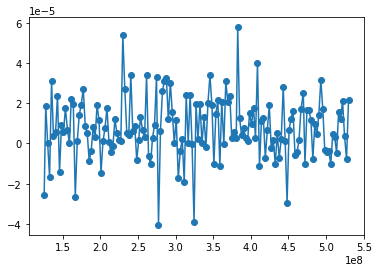

In [ ]:
# Quick plotting - 
from matplotlib import pyplot as plt
t, r=data1[0][0][0],data1[0][0][1][0,:]
#t1,r1=data1[0][0][0],data1[0][0][1].T[0] ## 
#print(data1[1][0])
plt.plot(t,r, 'o-')
#plt.plot(t1,r1,'s-')

## This part of the code will re-size the input data (155 features)

In [ ]:
## Matrix excercise

print(len(data1[1]))
test = np.array([ [[1., 2.,3.,4.], 
                 [3, 4,3,4], 
                 [5, 6,7,4],
                [9,8,9,4]],
               [[10, 20,30,40], 
                 [30, 40,30,40], 
                 [50, 60,70,40],
                [90,80,90,40]] ])
#print((test[1][0]-np.mean(test[1][0]))/np.var(test[1][0]))
test[1][0]=np.array((test[1][0]-np.mean(test[1][0]))/np.var(test[1][0]))
print(test)

1632
[[[ 1.0e+00  2.0e+00  3.0e+00  4.0e+00]
  [ 3.0e+00  4.0e+00  3.0e+00  4.0e+00]
  [ 5.0e+00  6.0e+00  7.0e+00  4.0e+00]
  [ 9.0e+00  8.0e+00  9.0e+00  4.0e+00]]

 [[-1.2e-01 -4.0e-02  4.0e-02  1.2e-01]
  [ 3.0e+01  4.0e+01  3.0e+01  4.0e+01]
  [ 5.0e+01  6.0e+01  7.0e+01  4.0e+01]
  [ 9.0e+01  8.0e+01  9.0e+01  4.0e+01]]]


In [ ]:
#print(data1[0][0][1][0:2,:])


In [ ]:
# This was created for a single time-series


timecol=data1[0][0][0]
# create the 155 column
rat1=data1[0][0][1]
ar1=np.concatenate(([timecol[0:155]],[rat1[0:155]]),  axis=0)
#print(len(data1[1]))
for i in range(len(data1[1])):
    #print(len(data1[0][i][1]))
    #if len(data1[0][i][1]) == 157:
    #    print("in here")
    #    #print(len(data1[0][i][1]))
        #mod_data=data1[0][i][1].append(data1[0][i][1][-1])
    #    ar1=np.concatenate((ar1,[mod_data]), axis=0)
 
    try:
        ar1=np.concatenate((ar1,[data1[0][i][1][0:155]]), axis=0)
        print(len(ar1))
    except:
        print('Some object has less than 155 observations')
        
    

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
#print(ar1[0:2])
#ar1[3]
df1=pd.DataFrame(ar1)
df1.head(n=10)
df1_t = df1.T
#df1_t.set_index([0], inplace=True)
#print(len(df1_transposed[0]))
#print(df1_t[1400])
print(len(df1))

NameError: name 'ar1' is not defined

In [ ]:
df1_t.head(n=10)
#print(df1_transposed[0].value)

,0,1,2,3,4,5,6,7
0,-2.578594e-05,1.602435e-05,0.000003,0.000032,9.883975e-06,9.478180e-06,1.201244e-05,7.162006e-07
1,1.878305e-05,1.847264e-05,0.000009,0.000017,3.786745e-06,2.853512e-06,8.862492e-06,5.545653e-06
2,3.874053e-07,1.029772e-05,0.000013,0.000003,6.285135e-06,6.020311e-06,3.362311e-06,7.794607e-06
3,-1.646436e-05,1.314300e-05,0.000018,0.000021,8.868953e-07,-1.668893e-06,-8.794782e-07,-3.974974e-06
4,3.110141e-05,-4.155375e-05,-0.000008,0.000015,1.213245e-05,1.828291e-05,-1.992983e-05,2.502033e-08
5,3.536495e-06,5.198035e-07,0.000023,0.000032,1.880362e-05,-3.904499e-07,5.276186e-06,1.175982e-05
6,5.620267e-06,4.460498e-06,0.000007,0.000007,4.705804e-06,5.575124e-06,5.900906e-07,3.261563e-06
7,2.382017e-05,-2.796128e-06,0.000012,0.000011,5.356789e-06,3.130812e-06,3.373962e-06,3.064498e-07
8,-1.437299e-05,-4.961665e-07,0.000003,0.000014,-1.745082e-05,9.296727e-06,2.543008e-06,-3.681516e-06
9,9.340739e-06,1.264583e-05,0.000010,0.000013,1.234839e-05,4.180259e-06,3.434571e-06,-4.338570e-06


## part of the code that creates a new simulated sample from the matrix

In [ ]:
# step 1,  iterate over the 1632 object
# step 2, for each object extract one band lc
# step 3, bootstrap that lightcurve and place is in the new simulated object
# 

#simulated data go here:
sim_data=[]

# function creating the simulated data
def boot_sim(obj, nsamp, r, c):
    #print(type(obj))
    new_sample=np.empty([nsamp, r, c])
    #print(new_sample.shape)
    for j in range(r):
        raw=obj[j]

        # operate bootstrap
        bts = BootstrappingWrapper(ConvolutionSmoother(window_len=4,  window_type='ones'), \
                           bootstrap_type='mbb', block_length=5)
        bts_samples = bts.sample(raw, n_samples=nsamp)
        for i  in range(nsamp):
            #print(new_sample[i][j].shape)
            #print(bts_samples.T.shape)
            
            new_sample[i][j]=bts_samples[i]
    return new_sample


#######################   simulation of data 
sim_sam=[]
nobj=2
for i in range(len(data1[0])):
    s=boot_sim(data1[0][i][1]*1e7,nobj,8,155)
    for j in range(nobj):
        sim_sam=np.append(sim_sam,np.array(s[j]).flatten())

print(sim_sam.shape)
print(8*155*nobj*len(data1[0]))

q=np.reshape(sim_sam,(nobj*len(data1[0]),8,155))
print(q[0].shape)

(4032480,)
4032480
(8, 155)


(8, 155)
1240


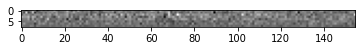

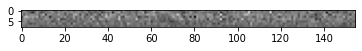

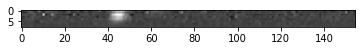

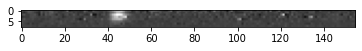

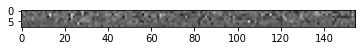

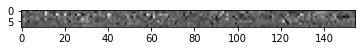

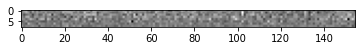

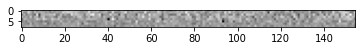

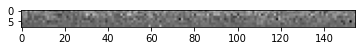

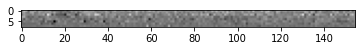

In [ ]:
print(np.array(data1[0][0][1]).shape)
print(155*8)
for i in range(10):
    fig, ax = plt.subplots()
    plt.imshow(q[i]/1e7,cmap='gray')
    #plt.imshow(np.array(data1[0][i][1])*1e7,cmap='gray')
plt.show()

In [ ]:
print(len(data1[0][0]))
mymin = [min(r[1]) for r in data1[0]]
print(mymin)

3


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
new=np.empty([4, 8, 155])
s=4
new=[]
for i in range(2):
    ciccio=boot_sim(data1[0][i][1],2,8,155)
    print(ciccio[1])
    for j in range(2):
        new=np.append(new,np.array(ciccio[j]).flatten())
    #for j in range(s):
    #    for z in range(2):
    #        new[s]=ciccio[z]
#print(new.shape)
#new=np.array([new,ciccio])
print(new.shape)
print(8*155*4)
q=np.reshape(new,(4,8,155))
print(q[1])
print

[[ 5.35850556e-06  4.69804590e-06 -1.87673867e-05 ...  2.22100221e-05
   1.37968866e-05 -1.45087405e-06]
 [-4.05476876e-06  2.89071835e-05  1.77090459e-05 ...  2.46084008e-06
   8.65675370e-06  2.57260156e-05]
 [ 2.39265645e-05 -6.54900939e-07  1.08438136e-05 ...  4.16229494e-05
   6.18589894e-06 -1.59831204e-05]
 ...
 [ 2.77043869e-06  1.50746978e-06  1.07692855e-05 ...  2.88812818e-06
  -2.78517891e-06 -1.38447529e-06]
 [-6.36331598e-06  1.38134908e-05  4.84569965e-06 ... -4.32685684e-06
   2.57328144e-06  8.80512148e-06]
 [ 2.52194835e-07  3.26790976e-06  2.84440773e-08 ... -7.94710942e-06
   2.32977928e-06  7.61140321e-06]]
[[ 2.21442625e-05  5.08874115e-05 -6.99242297e-07 ... -1.26921113e-05
  -5.68697693e-07 -2.88182821e-05]
 [-2.68622770e-05 -2.58282605e-05 -4.41798955e-06 ...  1.23745861e-05
  -2.04065356e-05 -1.47710925e-05]
 [ 1.59839807e-05 -1.77723915e-06  1.17882570e-05 ...  1.53056728e-05
   9.08591730e-08 -1.84004371e-05]
 ...
 [ 6.06290139e-06  2.32518352e-06  7.3969268

<function print>

In [ ]:
a=np.empty([2,3,4] )
a[0][0]=[1,2,3,5]
a[0][1]=[2,3,3,5]
a[0][2]=[0,0,0,5]
print(a[0][0].shape)
155*8

(4,)


1240

(155, 30)


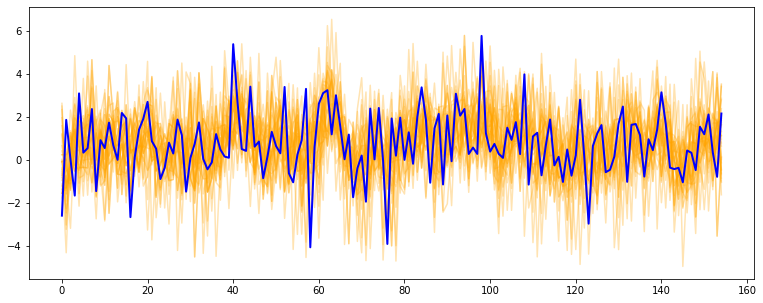

In [ ]:
#small piece for creating a bootstrapped sample of lightcurve

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.utils_func import sim_seasonal_data
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper

# generate a periodic timeseries of lenght 300
np.random.seed(123)
data = sim_seasonal_data(n_series=1, timesteps=300, 
                         freq=24, measure_noise=15)

#print(data[0])
#data=[df1_t[1200]]
#print(type(datap))

datap=data1[0][0][1][0,:]
#print(datap*1e5)
#df1=pd.DataFrame(datap)
#df1_t = df1.T
#data=[df1[1]]

# operate bootstrap
bts = BootstrappingWrapper(ConvolutionSmoother(window_len=5,  window_type='ones'), \
                           bootstrap_type='mbb', block_length=10)
bts_samples = bts.sample(datap*1e5, n_samples=30)

print(bts_samples.T.shape)
# plot the bootstrapped timeseries
plt.figure(figsize=(13,5))
plt.plot(bts_samples.T, alpha=0.3, c='orange')
plt.plot(datap*1e5, c='blue', linewidth=2)

In [ ]:
## Create the labels
# Read the URL table:
from urllib import request

table_157mo = pd.read_html('https://swift.gsfc.nasa.gov/results/bs157mon/',\
                            match='.+')
df = table_157mo[1]

sub_class = df[['BAT Name (a)', 'Counterpart Name','Class (j)','Type','RA (b)','Dec', 'Redshift (g)']]
tp=sub_class['Type'].values
names=sub_class['Counterpart Name'].values
rah,dech=sub_class['RA (b)'].values,sub_class['Dec'].values
bnames=sub_class['BAT Name (a)'].values
z=sub_class['Redshift (g)'].values
z[np.isnan(z)]=0.0
ld=cosmo.luminosity_distance(z).value*1e6

## Check the headers:
#f=fits.open('/Users/acucchiara/COM/proposal/SRP2021/work/BAT/BAT_157m_eight_band_monthly_lightcurve/BAT_157m_eight_band_SWIFT_J1626.7+8530.lc')
cut_names=[x for x in bnames]
#print(cut_names[0:4])
pairs=zip(tp,cut_names)
pairs_ar=(np.array(list(pairs)))


In [ ]:
print(ld[0:10])

[1.62945799e+08 2.59335545e+08 1.09124655e+08 1.72005608e+08
 4.40697172e+08 1.09124655e+08 3.29871725e+08 4.06629521e+08
 2.91813320e+10 4.35812400e+08]


In [ ]:
newbnames=np.array([x[6:] for x in bnames])
newfin=np.array([x[-15:-3] for x in file_list])
#print(type(newbnames),type(newfin))
match=[]
for i in newbnames:
    s=np.where(newfin == i)
    #print(s[0][0])
    try:
        match.append(s[0][0])
    except:
        #print('%s is not in the list' % str(i))
        pass
print(len(match))
    

1552


In [ ]:
for i in range(len(pairs_ar)): 
    ## modify the names to be able to match them with the transient catalog
    s=pairs_ar[i][1]
    p=s.replace("SWIFT ",'')
    pairs_ar[i][1]=p
    
    if pairs_ar[i][0] == 'Sy1.9' or pairs_ar[i][0] == 'Sy1.2' or \
    pairs_ar[i][0] == 'Sy1.5' or pairs_ar[i][0] == 'Sy1.8'or pairs_ar[i][0] == 'Sy1': pairs_ar[i][0]="1"
    elif pairs_ar[i][0] == 'Beamed AGN': pairs_ar[i][0]="2"
    elif pairs_ar[i][0] == 'Compact group of gal': pairs_ar[i][0]="3"
    elif pairs_ar[i][0] == 'Galactic Center' or pairs_ar[i][0] == 'GC': pairs_ar[i][0]="4"
    elif pairs_ar[i][0] == 'Galaxy Cluster': pairs_ar[i][0]="5"
    elif pairs_ar[i][0] == 'Gamma-ray source': pairs_ar[i][0]="6"
    elif pairs_ar[i][0] == 'Open star cluster': pairs_ar[i][0]="7"
    elif pairs_ar[i][0] == 'Sy1;broad-line AGN': pairs_ar[i][0]="8"
    elif pairs_ar[i][0] == 'Unknown AGN': pairs_ar[i][0]="9"
    elif pairs_ar[i][0] == 'molecular cloud': pairs_ar[i][0]="10"
    elif pairs_ar[i][0] == 'Starburst galaxy': pairs_ar[i][0]="11"
    elif pairs_ar[i][0] == 'Sy2 candidate': pairs_ar[i][0]="12"
    elif pairs_ar[i][0] == 'Symbiotic star': pairs_ar[i][0]="13"
    elif pairs_ar[i][0] == 'Pulsar': pairs_ar[i][0]="14"
    elif pairs_ar[i][0] == 'Sy2': pairs_ar[i][0]="15"    
    elif pairs_ar[i][0] == 'U1' : pairs_ar[i][0]="16"
    elif pairs_ar[i][0] == 'U2' : pairs_ar[i][0]="17"
    elif pairs_ar[i][0] == 'U3' : pairs_ar[i][0]="18"
    elif pairs_ar[i][0] == 'SNR' : pairs_ar[i][0]="19"
    elif pairs_ar[i][0] == 'HMXB' : pairs_ar[i][0]="20"
    elif pairs_ar[i][0] == 'CV' : pairs_ar[i][0]="21"
    elif pairs_ar[i][0] == 'LMXB' : pairs_ar[i][0]="22"
    elif pairs_ar[i][0] == 'XRB' : pairs_ar[i][0]="23"
    elif pairs_ar[i][0] == 'Nova' : pairs_ar[i][0]="24"
    elif pairs_ar[i][0] == 'star' : pairs_ar[i][0]="25"
    elif pairs_ar[i][0] == 'multiple' : pairs_ar[i][0]="26"
    elif pairs_ar[i][0] == 'LINER' : pairs_ar[i][0]="27"
        
        
print(pairs_ar[0:1000])

[['1' 'J0001.0-0708']
 ['1' 'J0001.6-7701']
 ['1' 'J0002.5+0323']
 ...
 ['15' 'J1845.4+7211']
 ['14' 'J1846.5-0257']
 ['1' 'J1852.2+8424A']]


In [ ]:
# create the pair [Obj-name, Type], we merged all Sy1, all Sy2
# we can try and ordinale encoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

enc.fit(pairs_ar)
enc.categories_[0]

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6',
       '7', '8', '9'], dtype='<U22')

In [ ]:
print(len(enc.categories_[0]),len(enc.categories_[1]))

26 1632


## Piece of code to label all the  simulate lightcurves from transient page

In [ ]:
# nobj is the object name list that we want to augment
# nam_list is the label list
nobj=data1[1]
nam_list=pairs_ar
label=[]
obj_ld=[]  # luminosity distance
for i in nobj:
    for j in nam_list:
        if i==j[1]: 
            label.append([i,j[0]])
            obj_ld.append(ld[j])
            
print(label[0:10])
print(len(label))

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
s="cicio2"
p=s.replace("c",'')
s=p
print(s)

iio2
